In [1]:
import astropy.io.fits as pf
import pylab as mplot
%pylab inline
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord
from pylab import cm
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

Populating the interactive namespace from numpy and matplotlib


In [2]:
planck_data = pf.open('HFI_PCCS_SZ-union_R2.08.fits')[1].data
sz_map = hp.read_map('COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits', nest=False)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


In [3]:
z = planck_data['redshift']
snr = planck_data['snr']
mass = planck_data['MSZ']
lon = planck_data['glon']
lat = planck_data['glat']
ra = planck_data['ra']
dec = planck_data['dec']

# find the 40 highest SNR clusters with 0<z<0.2
N = 10
id_snr = np.argsort(snr[(z>0)*(z<0.2)])[-1*N:][::-1]
snr_sel = snr[(z>0)*(z<0.2)][id_snr]

Z_sel = z[(z>0)*(z<0.2)][id_snr]
SNR_sel = snr[(z>0)*(z<0.2)][id_snr]
MASS_sel = mass[(z>0)*(z<0.2)][id_snr]
LON_sel, LAT_sel = lon[(z>0)*(z<0.2)][id_snr], lat[(z>0)*(z<0.2)][id_snr]
RA_sel, DEC_sel = ra[(z>0)*(z<0.2)][id_snr], dec[(z>0)*(z<0.2)][id_snr]

In [4]:
nside = 2048
pix = np.arange(hp.nside2npix(nside))
theta_y, phi_y = hp.pix2ang(nside, pix)
lon_y = phi_y/np.pi*180
lat_y = 90.-(theta_y/np.pi*180)

In [5]:
# first cluster has SZ mass M, assume SZ mass scales with M500, assume know R500 for first cluster is 18 arcmin
def M500_to_R500m(mass, z, cosmo):
    rho_m_z = cosmo.Om(z)*cosmo.critical_density(z)
    mass_units = mass*u.Msun
    R500m = ((mass_units/(500.*4.*np.pi*rho_m_z/3.))**(1./3.)).to('Mpc')
    return R500m.value

R500_MSZ = M500_to_R500m(MASS_sel[0]*10**14, Z_sel[0], cosmo)
Factor = R500_MSZ*(1+Z_sel[0])/(18./60/180*np.pi)/cosmo.comoving_distance(Z_sel[0]).value
print(Factor)

1.7599036881505379


R500 in arcmin 17.999999999999996


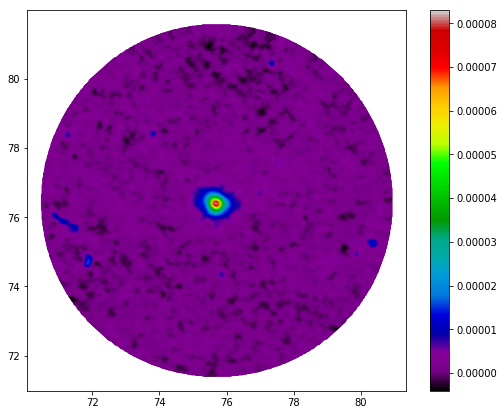

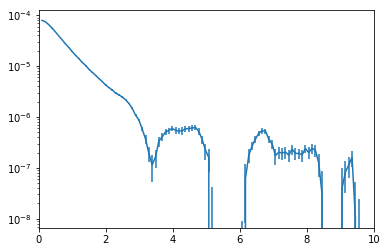

R500 in arcmin 15.410601608753057


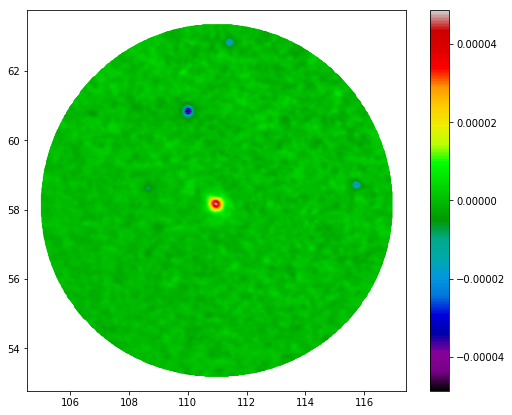

/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/chihwaychang/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


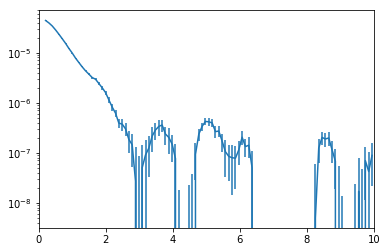

R500 in arcmin 15.544289937554153


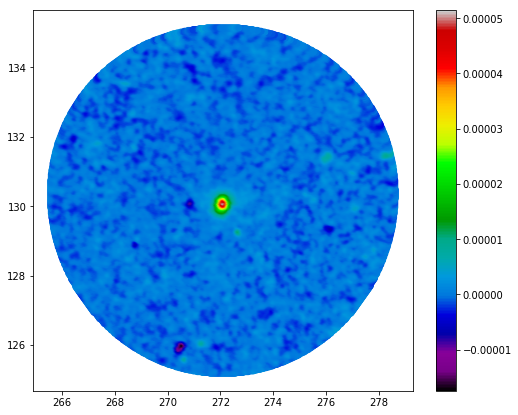

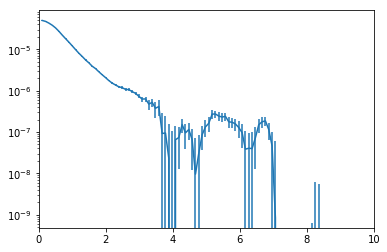

R500 in arcmin 17.05563678005392


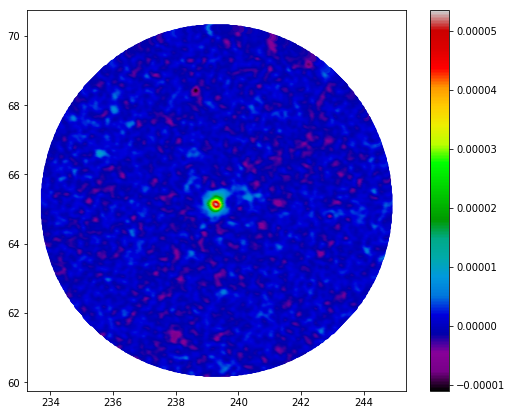

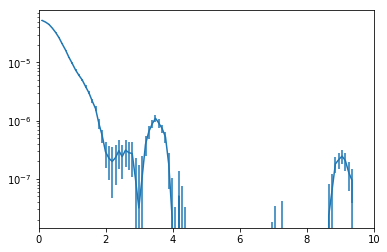

R500 in arcmin 40.324719370942


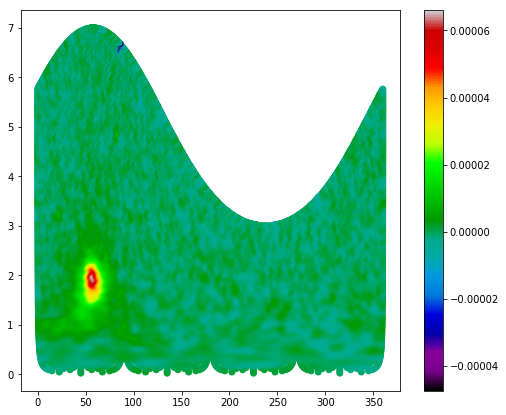

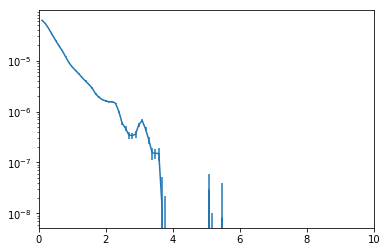

R500 in arcmin 19.09600275637768


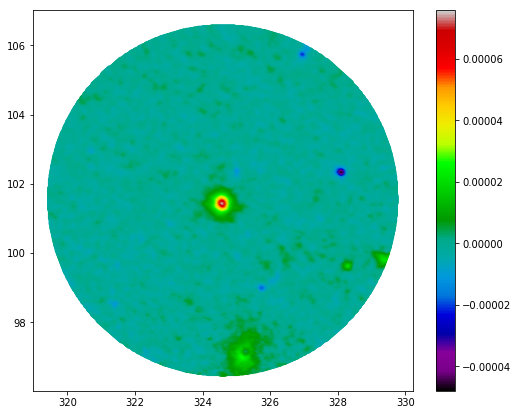

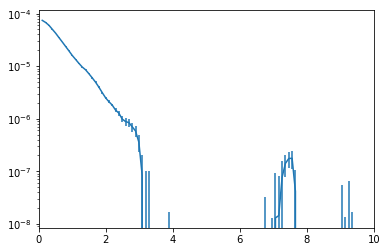

R500 in arcmin 11.31958075308116


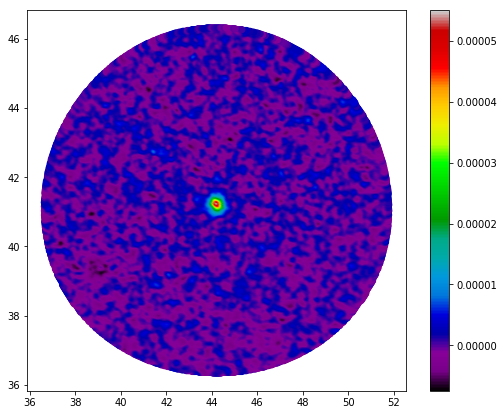

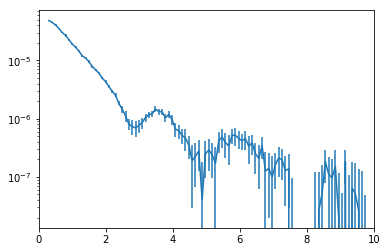

R500 in arcmin 16.777441461472012


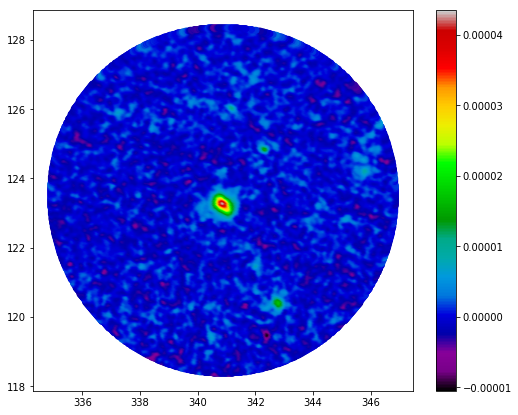

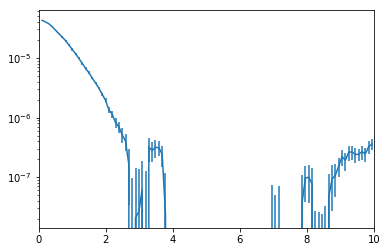

R500 in arcmin 10.60865674647252


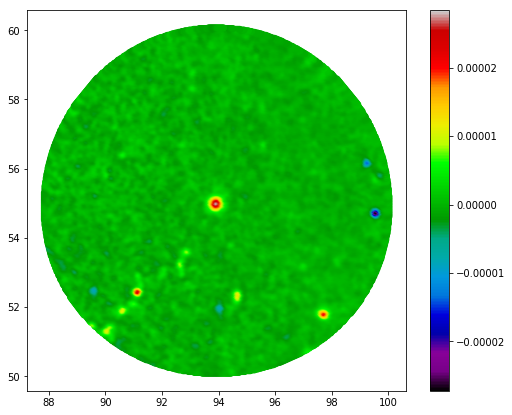

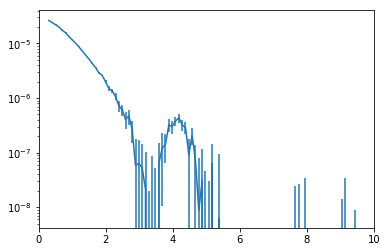

R500 in arcmin 12.240053799823494


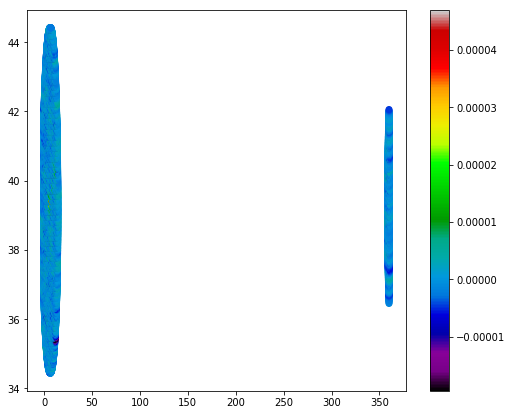

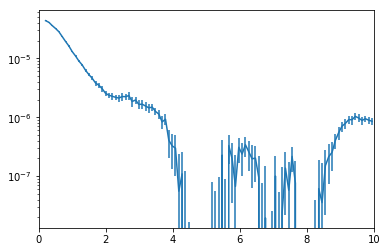

In [7]:
for i in range(10):

    R500 = (1+Z_sel[i])*M500_to_R500m(MASS_sel[i]*10**14/Factor**3, Z_sel[i], cosmo)/cosmo.comoving_distance(Z_sel[i]).value /np.pi*180.*60
    print('R500 in arcmin', R500)
    
    c1 = SkyCoord(LON_sel[i]*u.degree, LAT_sel[i]*u.degree, frame='icrs')
    c2 = SkyCoord(lon_y*u.degree, lat_y*u.degree, frame='icrs')
    sep = c1.separation(c2)
    mask_cluster = (sep.degree<5)

    mplot.figure(figsize=(8.5,7))
    mplot.scatter(lon_y[mask_cluster], (90. - lat_y[mask_cluster]), c=sz_map[mask_cluster], cmap='nipy_spectral')
    mplot.colorbar()
    mplot.show()


    ids = np.arange(len(sz_map[mask_cluster]))
    Npix = len(sz_map[mask_cluster])
    bg_mask = (sep.value[mask_cluster]>3)

    bin_edge = np.linspace(0.05, 10.0, num=101)
    bin_min = bin_edge[:-1]
    bin_max = bin_edge[1:]
    
    Y_boot = []
    Y_boot_err = []

    for j in range(100):
        ids_new = np.random.choice(ids, size=Npix, replace=True)

        c2_new = SkyCoord(lon_y[mask_cluster][ids_new]*u.degree, lat_y[mask_cluster][ids_new]*u.degree, frame='icrs')
        sep_new = c1.separation(c2_new)

        bg_mask_new = bg_mask[ids_new]
        bg = np.median(sz_map[mask_cluster][bg_mask_new])

        Y = []
        for k in range(100):
            R_over_R500 = np.array(sep_new.degree)/R500
            mask = (R_over_R500 >= bin_min[k]/60)*(R_over_R500 < bin_max[k]/60)
            Y.append(np.mean(sz_map[mask_cluster][ids_new][mask]))

        Y = np.array(Y)
        Y_boot.append(Y)

    Y_boot = np.array(Y_boot)

    Y_err = np.std(Y_boot, axis=0)
    Y_mean = np.mean(Y_boot, axis=0)

    DD = (bin_min+bin_max)/2

    mplot.errorbar(DD, Y_mean-bg, yerr=Y_err)
    mplot.yscale('log')
    mplot.xlim(0,10)
    mplot.show()
    
    cov_boot = np.cov(Y_boot.T)

    np.savez('Planck_cluster_bootstrap_scaled_'+str(i)+'.npz', ra=RA_sel[i], dec=DEC_sel[i], lon=LON_sel[i], 
             lat=LAT_sel[i], z=Z_sel[i], mass=MASS_sel[i], snr=SNR_sel[i], R_over_R500=(bin_min+bin_max)/2, 
             mean_y=Y_mean, bg=bg, cov=cov_boot)
    
    
 